In [2]:
# Sean Dougherty
# 15/5/2022
# ppc_agn_merger.py analysis notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats.distributions as dist

from time import sleep
from tqdm import tqdm

from astropy.io import fits

import pickle

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'

## PPC at different 2sigma cuts

In [ ]:
# # read in results
sig_cut = 10
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
rdf

In [ ]:
# # add an AGN count per pair column:
# rdf['mAGN'] = [0]*len(rdf)

# LX_AGN = 10**42
# rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
# rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

AGN_frac = {}
dif_cuts = {}
iso_count = {}
PDF_width = {}
sig_cuts = [10,3,2,1,0.5,0.25]
# sig_cuts = [1,0.5,0.25]


for sig_cut in sig_cuts:
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)

    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    PDF_width[str(sig_cut)] = np.zeros(len(bins))

    # split data frame up into each bin
    for i, rnge in enumerate(bins):
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]

        # calculating AGN per pair here
        AGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])) #* len(bin_df))
        PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 

    # get graphical data
    pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    dif_cuts[str(sig_cut)] = pAGN_fracs
    iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

In [ ]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [ ]:
# # well this didn't work bc no data but it should've
# # get graphical data
# pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [ ]:
# # plot results:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# ax.scatter(kpc_meds, pAGN_fracs)
# ax.set_xlim(0,100)
# plt.show()

In [ ]:
# PDF_width

In [ ]:
# dif_cuts[str(sig_cut)] = pAGN_fracs
# iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())
# marker = ['^','o','X','s','*','d'] * 8
# markers = np.transpose(np.reshape(marker, (8,3)))
kpcs = np.zeros((3,8))
for i in range(0,len(kpcs)):
    kpc_medu = [km+i for km in kpc_meds]
    kpcs[i] = kpc_medu
dif_cut = np.array([dif_cuts[key] for key in dif_cuts])
PDF_wid = np.array([PDF_width[key] for key in PDF_width])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
# ax.scatter(kpcs, dif_cut, s=100, c=PDF_wid)#, marker=markers)
# ax.set_ylim(0,0.12)
# ax.set_xlabel('kpc')
# ax.set_ylabel('AGN fraction')

# marker = ['^','o','X','s','*','d'] * 6
for i, key in enumerate(dif_cuts):
    kpc_medu = [km+i for km in kpc_meds]
    ax.scatter(kpc_medu, dif_cuts[key], s=100, c=PDF_width[key], marker=marker[i], edgecolors='black')
    ax.scatter(-100,-100, marker=marker[i], s=100, edgecolors='black', facecolor='white', label='2$\sigma$ = '+key)
    # ax.set_title('AGN fractions with different $\sigma$ criteria', fontsize=20)
    ax.set_xlim(0,105)
    ax.set_ylim(0,0.1)
    ax.set_xlabel('kpc', fontsize=15)
    ax.set_ylabel('AGN fraction', fontsize=15)
    ax.legend(fontsize=15)
    # cbar = fig.colorbar(pdat, ax=ax[0], vmax=2, vmin=0)
    # cbar.set_label('mean $2\sigma$', fontsize=15)
    # ax[1].bar(float(key), iso_count[key], label='2$\sigma$ = '+key)
    # ax[1].set_title('$N_{pairs} / N_{iso}$')

ax.set_xticks(np.arange(0,100,20))
ax.set_xticklabels(np.arange(0,100,20),fontsize=15)
ax.set_yticks(np.arange(0,0.11,0.02))
ax.set_yticklabels(np.arange(0,0.11,0.02),fontsize=15)

plt.savefig(PATH+'AP_PP_comparing_sigma.png')

plt.show()

## next plot the difference in AGN fraction at different pair_prob cuts


In [ ]:
prob_dat = {}
iso_count = {}
pair_count = {}

In [ ]:
# read in results
sig_cut = 0.25
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

In [ ]:
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# AGN_frac = {}

probc = [0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]

AGN_frac = {}
prob_dat = {}
iso_count = {}
pair_count = {}
npairs = {}

# sig_cuts = [10,3,2,1,0.5,0.25]
sig_cuts = [0.5,0.25]

for sig_cut in sig_cuts:
    print(sig_cut)
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)
    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    AGN_frac[str(sig_cut)] = np.zeros((len(probc), n_bins))
    npairs[str(sig_cut)] = np.zeros((len(probc),1))

    for i, p in enumerate(probc):
        rdf2 = rdf.loc[ (rdf['pair_prob'] > p) & (rdf['prime_M'] > 10) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]
        npairs[str(sig_cut)][i] = len(rdf2)

        # split data frame up into each bin
        for j, rnge in enumerate(bins):
            # get bin ranges from bins dictionary entries
            info = bins[rnge].split('-')
            low = float(info[0])
            high = float(info[1])

            # sort into bins
            bin_df = rdf2[ (rdf2['kpc_sep'] > low) & (rdf2['kpc_sep'] <= high) ]

            # calculating AGN per pair here
            AGN_frac[str(sig_cut)][i,j] = (sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (sum(bin_df['pair_prob'])))# * len(bin_df)))

    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    prob_dat = AGN_frac
    iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
    pair_count = npairs

In [ ]:
bin_df

In [ ]:
# # get graphical data
# # pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# prob_dat[str(sig_cut)] = AGN_frac
# iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
# pair_count[str(sig_cut)] = npairs

In [ ]:
# kpc_meds

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharey=True)
fig.subplots_adjust(wspace=0)

for k, key in enumerate(prob_dat):
    for i in range(0,len(prob_dat[key])):
        kpc_medu = [km+(i*1) for km in kpc_meds]
        ax[k].scatter(kpc_medu, prob_dat[key][i], label='$\mathcal{N}_z$ < '+str(probc[i]), s=50)
    #ax[k].set_ylim(0,8e-5)
    ax[k].set_ylim(0,0.12)
    ax[k].set_xlim(-5,105)
    ax[k].set_title('2$\sigma$ < '+key, fontsize=20)
    ax[k].legend(fontsize=15, ncol=2, loc='lower left')
    
ax[0].set_xticks(np.arange(0,105,20))
ax[0].set_xticklabels(np.arange(0,105,20),fontsize=15)
ax[0].set_yticks(np.arange(0,0.12,0.02))
ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)

ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].set_ylabel('AGN fraction', fontsize=15)


ax[1].set_xticks(np.arange(0,105,20))
ax[1].set_xticklabels(np.arange(0,105,20),fontsize=15)
    
plt.savefig(PATH+'AP_PP_comparing_prob_cuts.png')
    
plt.show()     

### remember this is AGN fraction per pairs ###

## Compare pair and control sample distributions:

In [45]:
# let's put the convolution values together (minus COSMOS)
fields = ['GDS','EGS','COS','GDN','UDS']#,'COSMOS']
ztype='p'
date='8.17'
dfs = {}
cdfs = {}
PdA_dfs = {}
# PdA_arr = np.zeros((1783360, 1500)) # need to see how long before loading but let's see...

all_len = 0
for field in tqdm(fields):
    # pair data
    file = 'conv_prob/conv_output/pair_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    dfs[field] = pd.read_csv(PATH+file)
    
    # PdA arrays
    with fits.open(PATH+'conv_prob/PdA_output/PdA_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
        PdA_dfs[field] = pd.DataFrame(data[0].data)
        
    # control data:
    cfile = 'conv_prob/control_output/control_N-2_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    cdfs[field] = pd.read_csv(PATH+cfile)

# dA = np.linspace(0, 200, num=2001)

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
print('concatinating PdA array... please wait.')
PdA_df = pd.concat(PdA_dfs).reset_index(drop=True)
PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
print('Done. Thanks for waiting!')
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] ))


# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] )) # for use_PdA True
### This will take a good chunk of time... ^^^
                            
### ~~~ WILL NEED TO THINK HOW TO INCORPORATE THE ACTUAL REDSHIFT THE PAIR WOULD OVER LAP AT ~~~ ###
                            # SIMPLY IN TERMS OF BINNING #
### ~~~ MIGHT ALSO WANTTO CONIDER PUTTING THE dA ARRAY INTO THE PdA FILE SOMEHOW ~~~ ###


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.87it/s]


concatinating PdA array... please wait.
Done. Thanks for waiting!


In [51]:
# I mean it worked... may consider wanting to make sure the two pairs chosen are wholly different, but may not actually matter
# ah but also want Cp to be within the same order of magitude, may need to do a log cut

# rename cdf columns to fit scheme for now:
pd.concat(cdfs).reset_index(drop=True)
columns={'ID1':'ID0', 'MASS1':'MASS0', 'z1':'z0', 'LX1':'LX0', 'IR_AGN_DON1':'IR_AGN_DON0', 'IR_AGN_STR1':'IR_AGN_STR0',
         'ID2':'ID1', 'MASS2':'MASS1', 'z2':'z1', 'LX2':'LX1', 'IR_AGN_DON2':'IR_AGN_DON1', 'IR_AGN_STR2':'IR_AGN_STR1'}

,ID1,RA1,DEC1,MASS1,z1,LX1,IR_AGN_DON1,IR_AGN_STR1,ID2,RA2,DEC2,MASS2,z2,LX2,IR_AGN_DON2,IR_AGN_STR2,arc_sep,Cp,P_ID1,P_ID2,Pp,dif,pair_ID,field
0,5812.0,53.077938,-27.858177,10.440000,0.57,-9.944176e+58,0.0,0.0,28582.0,53.226248,-27.859057,10.270000,2.74,-2.787083e+60,0.0,0.0,472.049112,1.376707e-18,1.0,5.0,6.105571e-19,0.002700,0.0,GDS
1,14465.0,53.234522,-27.787827,10.400000,0.56,7.581712e+40,0.0,0.0,28582.0,53.226248,-27.859057,10.270000,2.74,-2.787083e+60,0.0,0.0,257.774125,6.977836e-19,1.0,5.0,6.105571e-19,0.002800,0.0,GDS
2,8008.0,53.176799,-27.840346,10.430000,0.54,-8.828192e+58,0.0,0.0,3715.0,53.130758,-27.877806,10.180000,1.14,-4.529897e+59,0.0,0.0,199.146984,7.432216e-09,1.0,40.0,1.413431e-08,0.002600,1.0,GDS
3,22420.0,53.097519,-27.721271,10.440000,0.55,-9.192099e+58,0.0,0.0,8154.0,53.228947,-27.835334,10.200000,1.16,-4.702803e+59,0.0,0.0,586.389341,3.483226e-08,1.0,40.0,1.413431e-08,0.005800,1.0,GDS
4,8008.0,53.176799,-27.840346,10.430000,0.54,-8.828192e+58,0.0,0.0,19486.0,53.032206,-27.745338,10.150000,1.87,-1.288301e+60,0.0,0.0,573.612212,5.129578e-18,1.0,26839.0,2.677961e-18,0.003700,2.0,GDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27759,5389.0,34.318147,-5.245285,11.421604,2.56,-2.435515e+60,0.0,1.0,10152.0,34.589995,-5.219651,10.532754,2.04,-1.540294e+60,0.0,0.0,978.930765,1.892015e-02,27729.0,2134.0,8.355082e-03,0.022439,2663.0,UDS
27760,5732.0,34.352335,-5.243157,10.324282,2.84,-2.991284e+60,0.0,0.0,12368.0,34.386526,-5.207143,10.056905,2.36,-2.069598e+60,0.0,0.0,178.421705,2.386730e-02,30325.0,10087.0,2.462385e-02,0.002637,2664.0,UDS
27761,19776.0,34.255639,-5.166550,10.243038,2.79,-2.888400e+60,0.0,0.0,25392.0,34.321439,-5.133450,10.017033,2.36,-2.069598e+60,0.0,0.0,264.306831,3.439150e-02,30325.0,10087.0,2.462385e-02,0.005744,2664.0,UDS
27762,17905.0,34.267983,-5.177386,10.146128,2.69,-2.687347e+60,0.0,0.0,6432.0,34.448991,-5.239656,10.041393,2.44,-2.212794e+60,0.0,0.0,686.564969,4.312651e-03,32849.0,17934.0,1.180884e-02,0.001773,2665.0,UDS


In [46]:
# right now we are working with just two, but we will want to have this work for any number of N we select
# store number of controls in save file:
# control_N-2_ztype-ps_COSMOS_8.16.csv'
(3/100)*81000 / 60 # = ~40 ==> less than 2 days for COSMOS
# there are probably more sophisticated ways to throw processors at the COSMOS selection
# maybe join processors after pairs are found then resend them to quadrants
# also seems tobe busted for GDN
### ~~~ could be the merge process is the real killer ~~~ ###

40.5

In [47]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [48]:
# create bins:
max_dist=150
n_bins=10
resolve = False
use_PdA = True # resolving in this case is pointless, so don't worry about that switch when this one is on
mass_ratio = 1 #np.log10(4) # major mergers
bottom = 0
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)
# PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
dA = np.linspace(0, 200, num=2001)
LX_AGN = 42

# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True)
cdf = pd.concat(cdfs).reset_index(drop=True)
# cdf = cdf.rename(columns={'ID1':'ID0', 'MASS1':'MASS0', 'z1':'z0', 'LX1':'LX0', 'IR_AGN_DON1':'IR_AGN_DON0', 'IR_AGN_STR1':'IR_AGN_STR0',
#          'ID2':'ID1', 'MASS2':'MASS1', 'z2':'z1', 'LX2':'LX1', 'IR_AGN_DON2':'IR_AGN_DON1', 'IR_AGN_STR2':'IR_AGN_STR1'})

# no just match based on pair ID strings as so
rdf['pair_ID'] = rdf['field'] +'_'+ (rdf['prime_ID'].astype(int)).astype(str) +'+'+ (rdf['partner_ID'].astype(int)).astype(str)
cdf['pair_ID'] = cdf['field'] +'_'+ (cdf['P_ID1'].astype(int)).astype(str) +'+'+ (cdf['P_ID2'].astype(int)).astype(str)
cdf['apple_ID'] = cdf['field'] +'_'+ (cdf['ID1'].astype(int)).astype(str) +'+'+ (cdf['ID2'].astype(int)).astype(str)

# get the N_controls selected from bobbing method:
N_controls = int(cfile.split('/')[-1].split('_')[1][2]) # should work, also don't need to do things this way

# add an AGN count per pair column:
rdf['pXAGN_1'] = [0]*len(rdf)
rdf['pXAGN_2'] = [0]*len(rdf)
rdf['pDoAGN_1'] = [0]*len(rdf)
rdf['pDoAGN_2'] = [0]*len(rdf)
rdf['pStAGN_1'] = [0]*len(rdf)
rdf['pStAGN_2'] = [0]*len(rdf)
rdf.loc[ np.log10(rdf['prime_LX']) > LX_AGN, 'pXAGN_1' ] = 1
rdf.loc[ np.log10(rdf['partner_LX']) > LX_AGN, 'pXAGN_2' ] = 1
rdf.loc[ rdf['prime_IR_AGN_DON'] == 1, 'pDoAGN_1' ] = 1
rdf.loc[ rdf['partner_IR_AGN_DON'] == 1, 'pDoAGN_2' ] = 1
rdf.loc[ rdf['prime_IR_AGN_STR'] == 1, 'pStAGN_1' ] = 1
rdf.loc[ rdf['partner_IR_AGN_STR'] == 1, 'pStAGN_2' ] = 1
cdf['iXAGN_1'] = [0]*len(cdf)
cdf['iXAGN_2'] = [0]*len(cdf)
cdf['iDoAGN_1'] = [0]*len(cdf)
cdf['iDoAGN_2'] = [0]*len(cdf)
cdf['iStAGN_1'] = [0]*len(cdf)
cdf['iStAGN_2'] = [0]*len(cdf)
cdf.loc[ np.log10(cdf['LX1']) > LX_AGN, 'iXAGN_1' ] = 1
cdf.loc[ np.log10(cdf['LX2']) > LX_AGN, 'iXAGN_2' ] = 1
cdf.loc[ cdf['IR_AGN_DON1'] == 1, 'iDoAGN_1' ] = 1
cdf.loc[ cdf['IR_AGN_DON2'] == 1, 'iDoAGN_2' ] = 1
cdf.loc[ cdf['IR_AGN_STR1'] == 1, 'iStAGN_1' ] = 1
cdf.loc[ cdf['IR_AGN_STR2'] == 1, 'iStAGN_2' ] = 1

rdf = rdf.loc[ (rdf['partner_M'] > 10) & (rdf['prime_z'] < 3.0) & #(rdf['field'] == 'COSMOS') &
          (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] < mass_ratio) ]

# no just match based on pair ID strings as so

cdf = cdf.loc[ (cdf['pair_ID'].isin(rdf['pair_ID']) == True) ]

# would need to make the same cuts to PdA...

pAGN_frac = {}
iAGN_frac = {}
pAGN_count, iAGN_count = {}, {} #

tot_pair = {}
tot_iso = {}

bin_dfs = {} # to look at dfs in post

pXAGN_frac, iXAGN_frac = {}, {}
pXAGN_count, iXAGN_count = {}, {}
pDoAGN_frac, iDoAGN_frac = {}, {}
pDoAGN_count, iDoAGN_count = {}, {}
pStAGN_frac, iStAGN_frac = {}, {}
pStAGN_count, iStAGN_count = {}, {}

# keep track of uncertainties:
pXAGN_err, iXAGN_err = {}, {}
pDoAGN_err, iDoAGN_err = {}, {}
pStAGN_err, iStAGN_err = {}, {}
p_err, i_err = {}, {}

p_probs = {}
i_probs = {}
p_wprobs = {}
i_wprobs = {}
ID_bin, field_bin = {}, {}
iID_bin, ifield_bin = {}, {}
c_dfd = {} # dictionary of dataframes for each bin for the control galaxy selection
pz_bin, pmass_bin, psig_bin = {},{},{}
iz_bin, imass_bin, isig_bin = {},{},{}

# collect distribution of entire data
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) ) # no longer care about this

iz = np.concatenate( (cdf['z1'], cdf['z2']) )
imass = np.concatenate( (cdf['MASS1'], cdf['MASS2']) )
# isig = ...

# split data frame up into each bin
for i, rnge in tqdm(enumerate(bins)):
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])

    if use_PdA == False:
        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['kpc_sep'] > 4) ]
        ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]
        # raise KeyboardInterrupt

        bin_dfs[bins[rnge]] = bin_df

        ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###

        # resolve duplicates <- make a switch for this, and do it for all AGN count methods...
        if resolve == True:
            bin_probs = []
            bin_ID, bin_field = [], []
            bin_pz, bin_pm , bin_psig = [],[],[]
            bin_XAGN, bin_DoAGN, bin_StAGN = [], [], []
            for field in bin_df['field'].unique():
                # stack prime partner indices, pair_prob, AGN (0 or 1)
                all_ID = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'prime_ID'], bin_df.loc[bin_df['field'] == field, 'partner_ID']) )
                all_field = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'field'], bin_df.loc[bin_df['field'] == field, 'field']) )
                all_prob = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pair_prob'], bin_df.loc[bin_df['field'] == field, 'pair_prob']) )
                all_pz = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'prime_z'], bin_df.loc[bin_df['field'] == field, 'partner_z']) )
                all_pm = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'prime_M'], bin_df.loc[bin_df['field'] == field, 'partner_M']) )
                all_psig = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'prime_PDFsig'], bin_df.loc[bin_df['field'] == field, 'partner_PDFsig']) )
                all_XAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pXAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pXAGN_PA']) )
                all_DoAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pDoAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pDoAGN_PA']) )
                all_StAGN = np.concatenate( (bin_df.loc[bin_df['field'] == field, 'pStAGN_PR'], bin_df.loc[bin_df['field'] == field, 'pStAGN_PA']) )
                # sort out duplicates
                unq_id, sort_idx, counts = np.unique(all_ID, return_index=True, return_counts=True)

                for i in range(0, len(counts)):
                    if counts[i] > 1:
                        dup_idx = unq_id[i]
                        dup_prob = all_prob[np.where(all_ID == dup_idx)]
                        max_prob = max(dup_prob)
                        all_prob[np.where(all_ID == dup_idx)] = max_prob

                sort_field = all_field[sort_idx]
                sort_prob = all_prob[sort_idx]
                sort_pz = all_pz[sort_idx]
                sort_pm = all_pm[sort_idx]
                sort_psig = all_psig[sort_idx]
                sort_XAGN = all_XAGN[sort_idx]
                sort_DoAGN = all_DoAGN[sort_idx]
                sort_StAGN = all_StAGN[sort_idx]
                bin_ID.append(unq_id)              #####
                bin_field.append(sort_field)
                bin_probs.append(sort_prob)
                bin_pz.append(sort_pz)
                bin_pm.append(sort_pm)
                bin_psig.append(sort_psig)
                bin_XAGN.append(sort_XAGN)
                bin_DoAGN.append(sort_DoAGN)
                bin_StAGN.append(sort_StAGN)

            bin_ID = np.concatenate(np.array(bin_ID, dtype=object))
            bin_field = np.concatenate(np.array(bin_field, dtype=object))
            bin_probs = np.concatenate(np.array(bin_probs, dtype=object))
            bin_pz = np.concatenate(np.array(bin_pz, dtype=object))
            bin_pm = np.concatenate(np.array(bin_pm, dtype=object))
            bin_psig = np.concatenate(np.array(bin_psig, dtype=object))
            bin_XAGN = np.concatenate(np.array(bin_XAGN, dtype=object))
            bin_DoAGN = np.concatenate(np.array(bin_DoAGN, dtype=object))
            bin_StAGN = np.concatenate(np.array(bin_StAGN, dtype=object))

            # store distribution information (including weights)
            ID_bin[bins[rnge]] = bin_ID
            field_bin[bins[rnge]] = bin_field
            p_probs[bins[rnge]] = bin_probs
            pz_bin[bins[rnge]] = bin_pz
            pmass_bin[bins[rnge]] = bin_pm
            psig_bin[bins[rnge]] = bin_psig
            c_dfd[bins[rnge]] = pd.DataFrame( {'ID':bin_ID, 'field':bin_field, 'pair_prob':bin_probs,
                                               'z':bin_pz, 'mass':bin_pm, '2sig':bin_psig} )

            # store counts for table
            pXAGN_count[bins[rnge]] = [sum(bin_probs*bin_XAGN)]
            pDoAGN_count[bins[rnge]] = [sum(bin_probs*bin_DoAGN)]
            pStAGN_count[bins[rnge]] = [sum(bin_probs*bin_StAGN)]

            # calculate AGN fractions
            pXAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_XAGN) / sum(bin_probs) ]
            pDoAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_DoAGN) / sum(bin_probs) ]
            pStAGN_frac[bins[rnge]] = [ sum(bin_probs*bin_StAGN) / sum(bin_probs) ]

            # will need to redefine total counts as well (at least now for pairs)
            tot_pair[bins[rnge]] = [sum(bin_probs)]

        else:
            bin_ID = np.concatenate((bin_df['prime_ID'], bin_df['partner_ID']))
            bin_field = np.concatenate((bin_df['field'], bin_df['field']))
            bin_probs = np.concatenate((bin_df['pair_prob'], bin_df['pair_prob']))
            bin_pz = np.concatenate((bin_df['prime_z'], bin_df['partner_z']))
            bin_pm = np.concatenate((bin_df['prime_M'], bin_df['partner_M']))
            bin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
            bin_XAGN = np.concatenate((bin_df['pXAGN_1'], bin_df['pXAGN_2']))
            bin_DoAGN = np.concatenate((bin_df['pDoAGN_1'], bin_df['pDoAGN_2']))
            bin_StAGN = np.concatenate((bin_df['pStAGN_1'], bin_df['pStAGN_2']))
            ibin_ID = np.concatenate((ibin_df['ID1'], ibin_df['ID2']))
            ibin_field = np.concatenate((ibin_df['field'], ibin_df['field']))
            ibin_probs = np.concatenate((ibin_df['Cp'], ibin_df['Cp']))
            ibin_z = np.concatenate((ibin_df['z1'], ibin_df['z2']))
            ibin_m = np.concatenate((ibin_df['MASS1'], ibin_df['MASS2']))
            # ibin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
            ibin_XAGN = np.concatenate((ibin_df['iXAGN_1'], ibin_df['iXAGN_2']))
            ibin_DoAGN = np.concatenate((ibin_df['iDoAGN_1'], ibin_df['iDoAGN_2']))
            ibin_StAGN = np.concatenate((ibin_df['iStAGN_1'], ibin_df['iStAGN_2']))
            

            # store distribution information (including weights)
            ID_bin[bins[rnge]] = bin_ID
            field_bin[bins[rnge]] = bin_field
            p_probs[bins[rnge]] = bin_probs
            pz_bin[bins[rnge]] = bin_pz
            pmass_bin[bins[rnge]] = bin_pm
            psig_bin[bins[rnge]] = bin_psig             # don't need to do this (below)
            c_dfd[bins[rnge]] = pd.DataFrame( {'ID':bin_ID, 'field':bin_field, 'pair_prob':bin_probs,
                                               'z':bin_pz, 'mass':bin_pm, '2sig':bin_psig} )
            iID_bin[bins[rnge]] = ibin_ID
            ifield_bin[bins[rnge]] = ibin_field
            i_probs[bins[rnge]] = ibin_probs
            iz_bin[bins[rnge]] = ibin_z
            imass_bin[bins[rnge]] = ibin_m

            # store counts for table
            pXAGN_count[bins[rnge]] = np.sum(bin_probs*bin_XAGN)
            pDoAGN_count[bins[rnge]] = np.sum(bin_probs*bin_DoAGN)
            pStAGN_count[bins[rnge]] = np.sum(bin_probs*bin_StAGN)
            iXAGN_count[bins[rnge]] = np.sum(ibin_probs*ibin_XAGN)
            iDoAGN_count[bins[rnge]] = np.sum(ibin_probs*ibin_DoAGN)
            iStAGN_count[bins[rnge]] = np.sum(ibin_probs*ibin_StAGN)

            pXAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_probs*bin_XAGN)**2))
            pDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_probs*bin_DoAGN)**2))
            pStAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_probs*bin_StAGN)**2))
            p_err[bins[rnge]] = np.sqrt(np.sum(bin_probs**2))
            iXAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_probs*ibin_XAGN)**2))
            iDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_probs*ibin_DoAGN)**2))
            iStAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_probs*ibin_StAGN)**2))
            i_err[bins[rnge]] = np.sqrt(np.sum(ibin_probs**2))

            # calculate AGN fractions
            pXAGN_frac[bins[rnge]] = np.sum(bin_probs*bin_XAGN) / sum(bin_probs) 
            pDoAGN_frac[bins[rnge]] = np.sum(bin_probs*bin_DoAGN) / sum(bin_probs) 
            pStAGN_frac[bins[rnge]] = np.sum(bin_probs*bin_StAGN) / sum(bin_probs) 
            iXAGN_frac[bins[rnge]] = np.sum(ibin_probs*ibin_XAGN) / sum(ibin_probs) 
            iDoAGN_frac[bins[rnge]] = np.sum(ibin_probs*ibin_DoAGN) / sum(ibin_probs) 
            iStAGN_frac[bins[rnge]] = np.sum(ibin_probs*ibin_StAGN) / sum(ibin_probs) 

            # total counts are
            tot_pair[bins[rnge]] = np.sum(bin_probs)
            tot_iso[bins[rnge]] = np.sum(ibin_probs)
            
            
    elif use_PdA == True:
        bin_df = rdf  #[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['kpc_sep'] > 4) ]
        # bin_df = rdf[ (rdf['kpc_sep'] > 3) ]
        ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]
        bin_dfs[bins[rnge]] = bin_df           ### ~~~ WILL NEED TO UPDATE THE PROBABILITIES FOR CONTROL SELECTION ~~~ ###
        
        bin_ID = np.concatenate((bin_df['prime_ID'], bin_df['partner_ID']))
        bin_field = np.concatenate((bin_df['field'], bin_df['field']))
        bin_probs = np.concatenate((bin_df['pair_prob'], bin_df['pair_prob']))
        bin_pz = np.concatenate((bin_df['prime_z'], bin_df['partner_z']))
        bin_pm = np.concatenate((bin_df['prime_M'], bin_df['partner_M']))
        bin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
        bin_XAGN = np.concatenate((bin_df['pXAGN_1'], bin_df['pXAGN_2']))
        bin_DoAGN = np.concatenate((bin_df['pDoAGN_1'], bin_df['pDoAGN_2']))
        bin_StAGN = np.concatenate((bin_df['pStAGN_1'], bin_df['pStAGN_2']))
        ibin_ID = np.concatenate((ibin_df['ID1'], ibin_df['ID2']))
        ibin_field = np.concatenate((ibin_df['field'], ibin_df['field']))
        ibin_probs = np.concatenate((ibin_df['Cp'], ibin_df['Cp']))
        ibin_z = np.concatenate((ibin_df['z1'], ibin_df['z2']))
        ibin_m = np.concatenate((ibin_df['MASS1'], ibin_df['MASS2']))
        # ibin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
        ibin_XAGN = np.concatenate((ibin_df['iXAGN_1'], ibin_df['iXAGN_2']))
        ibin_DoAGN = np.concatenate((ibin_df['iDoAGN_1'], ibin_df['iDoAGN_2']))
        ibin_StAGN = np.concatenate((ibin_df['iStAGN_1'], ibin_df['iStAGN_2']))
        
        bin_PdA = PdA_arr[rdf.index] # may need to be bin_df.index, but no difference obv
        if i == 0: # should be the closest bin
            low = 4 ### ~~~ THINK ABOUT THIS MORE LATER ~~~ ###
            
        bin_weights = np.trapz(bin_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
        bin_weights = np.concatenate((bin_weights[:,0], bin_weights[:,0])) # may need to concatenate bin_weights[:,0]
        # gonna need this for iso probs too
        bin_wei_probs = bin_probs*bin_weights
        ibin_wei_probs = ibin_probs*np.repeat(bin_weights, N_controls)
        
         # store distribution information (including weights)
        ID_bin[bins[rnge]] = bin_ID
        field_bin[bins[rnge]] = bin_field
        p_probs[bins[rnge]] = bin_probs
        p_wprobs[bins[rnge]] = bin_wei_probs
        pz_bin[bins[rnge]] = bin_pz
        pmass_bin[bins[rnge]] = bin_pm
        psig_bin[bins[rnge]] = bin_psig
        c_dfd[bins[rnge]] = pd.DataFrame( {'ID':bin_ID, 'field':bin_field, 'pair_prob':bin_probs, 'PdA_prob':bin_wei_probs,
                                           'z':bin_pz, 'mass':bin_pm, '2sig':bin_psig} )
        iID_bin[bins[rnge]] = ibin_ID
        ifield_bin[bins[rnge]] = ibin_field
        i_probs[bins[rnge]] = ibin_probs
        i_wprobs[bins[rnge]] = ibin_wei_probs
        iz_bin[bins[rnge]] = ibin_z
        imass_bin[bins[rnge]] = ibin_m
        
        # store counts for table
        pXAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_XAGN)
        pDoAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN)
        pStAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN)
        iXAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_XAGN)
        iDoAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN)
        iStAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN)

        pXAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_XAGN)**2))
        pDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_DoAGN)**2))
        pStAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_StAGN)**2))
        p_err[bins[rnge]] = np.sqrt(np.sum(bin_wei_probs**2))
        iXAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_XAGN)**2))
        iDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_DoAGN)**2))
        iStAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_StAGN)**2))
        i_err[bins[rnge]] = np.sqrt(np.sum(ibin_wei_probs**2))

        # calculate AGN fractions
        pXAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_XAGN) / sum(bin_wei_probs) 
        pDoAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN) / sum(bin_wei_probs) 
        pStAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN) / sum(bin_wei_probs) 
        iXAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_XAGN) / sum(ibin_wei_probs) 
        iDoAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN) / sum(ibin_wei_probs) 
        iStAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN) / sum(ibin_wei_probs)

        # total counts are
        tot_pair[bins[rnge]] = np.sum(bin_wei_probs)
        tot_iso[bins[rnge]] = np.sum(ibin_wei_probs)
        
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###

    
# get graphical data
pXAGN_fracs = np.array([pXAGN_frac[col] for col in pXAGN_frac])
pDoAGN_fracs = np.array([pDoAGN_frac[col] for col in pDoAGN_frac])
pStAGN_fracs = np.array([pStAGN_frac[col] for col in pStAGN_frac])
iXAGN_fracs = np.array([iXAGN_frac[col] for col in iXAGN_frac])
iDoAGN_fracs = np.array([iDoAGN_frac[col] for col in iDoAGN_frac])
iStAGN_fracs = np.array([iStAGN_frac[col] for col in iStAGN_frac])

kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])
# AGN_enh = (pAGN_fracs) /(iAGN_fracs)

p_probss = [p_probs[col] for col in p_probs]
pz_bins = [pz_bin[col] for col in pz_bin]
pmass_bins = [pmass_bin[col] for col in pmass_bin]
# psig_bins = [psig_bin[col] for col in psig_bin]
i_probss = [i_probs[col] for col in i_probs]
iz_bins = [iz_bin[col] for col in iz_bin]
imass_bins = [imass_bin[col] for col in imass_bin]
# isig_bins = [isig_bin[col] for col in isig_bin]

tot_pairs = np.array([tot_pair[col] for col in tot_pair])
tot_isos = np.array([tot_iso[col] for col in tot_iso])

print('Done!')


/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
10it [00:01,  5.63it/s]

Done!


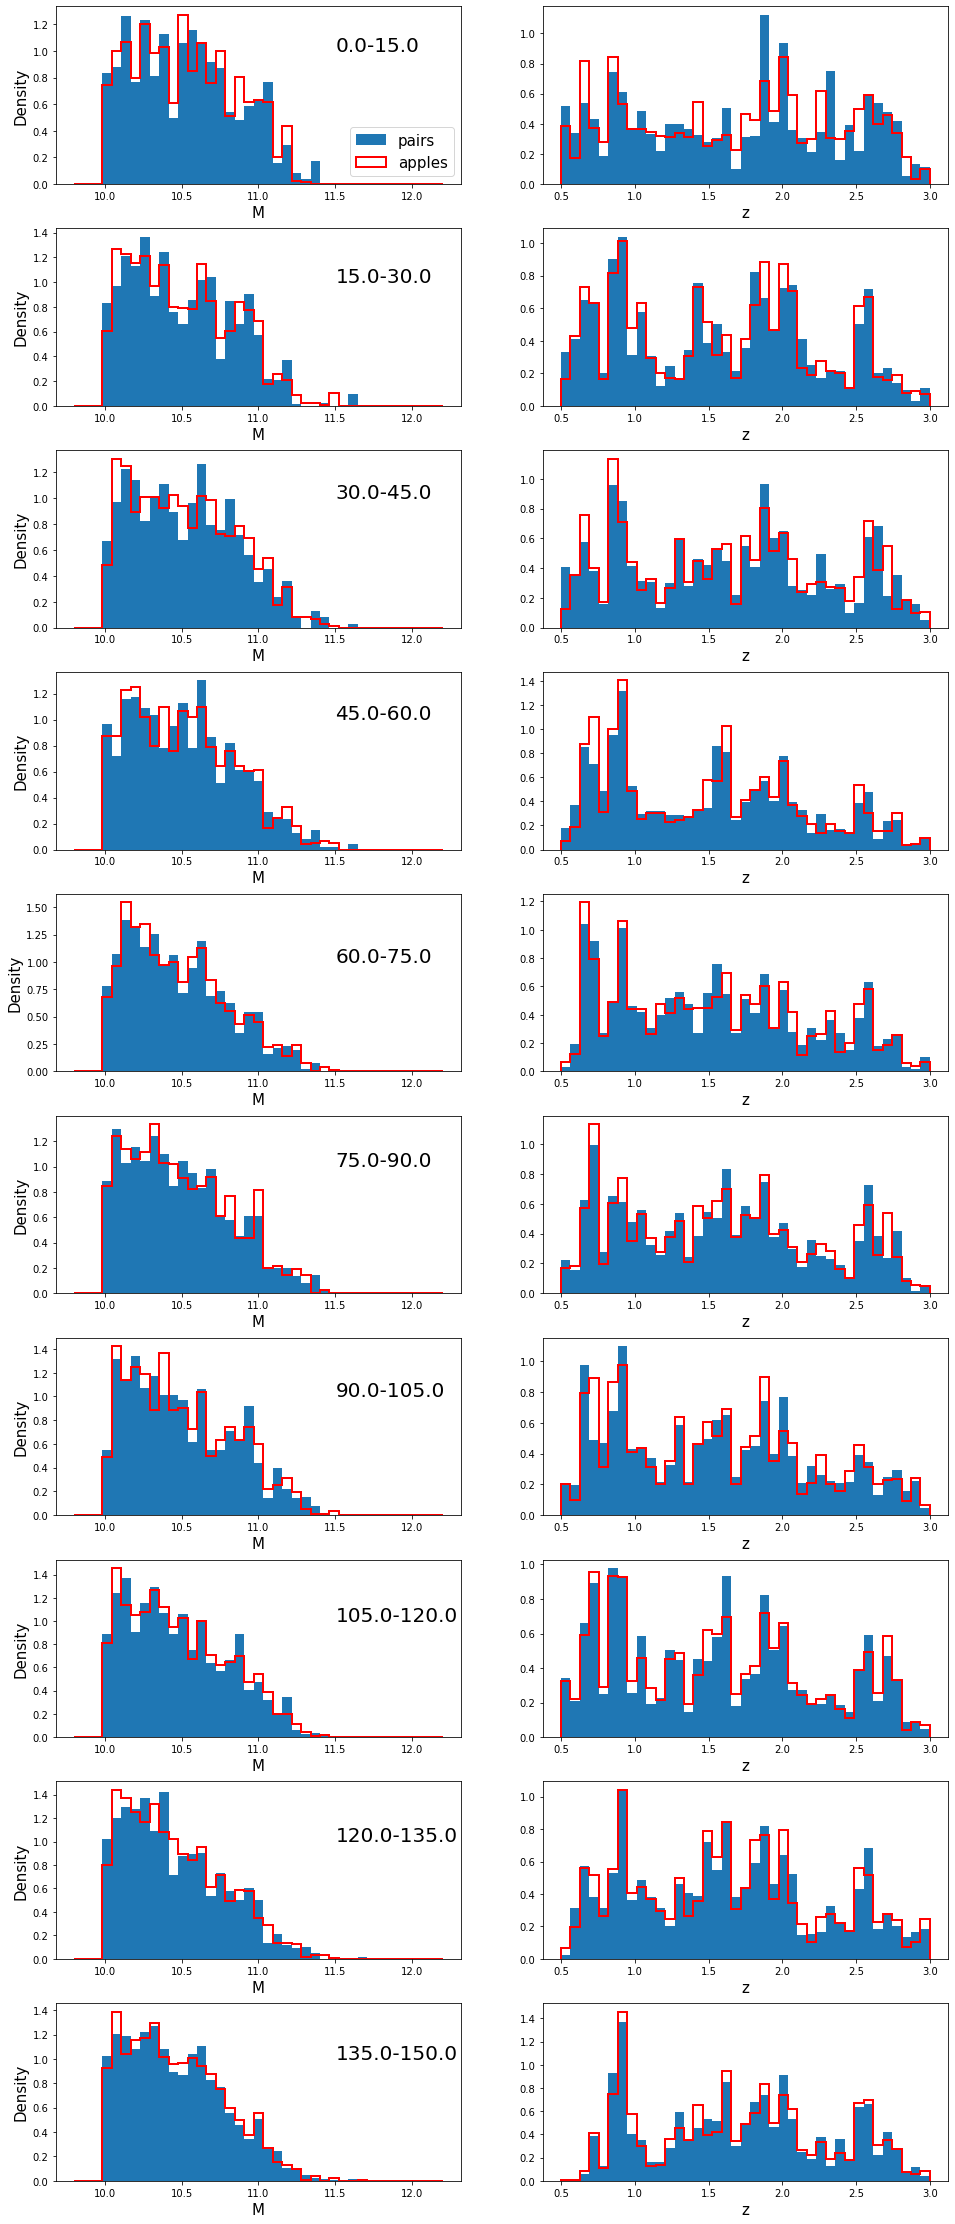

In [49]:
# let's look at the distributions for each key:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(16,40))
fig.subplots_adjust(hspace=0.25)
mbins = np.linspace(9.8, 12.2, 40)
zbins = np.linspace(0.5, 3, 40)
for i, key in enumerate(bin_dfs):
    ax[i,0].hist(pmass_bin[key], bins=mbins, weights=p_wprobs[key], density=True, label='pairs')
    ax[i,1].hist(pz_bin[key], bins=zbins, weights=p_wprobs[key], density=True)
    ax[i,0].hist(imass_bin[key], bins=mbins, weights=i_wprobs[key], density=True, histtype='step', color='red', lw=2,
                label='apples')
    ax[i,1].hist(iz_bin[key], bins=zbins, weights=i_wprobs[key], density=True, histtype='step', color='red', lw=2)
    ax[i,0].text(11.5, 1, key, fontsize=20)
    
    ax[i,0].set_xlabel('M', fontsize=15)
    ax[i,1].set_xlabel('z', fontsize=15)
    ax[i,0].set_ylabel('Density', fontsize=15)
    
    if i == 0:
        ax[i,0].legend(fontsize=15, loc=4)
    
plt.show()

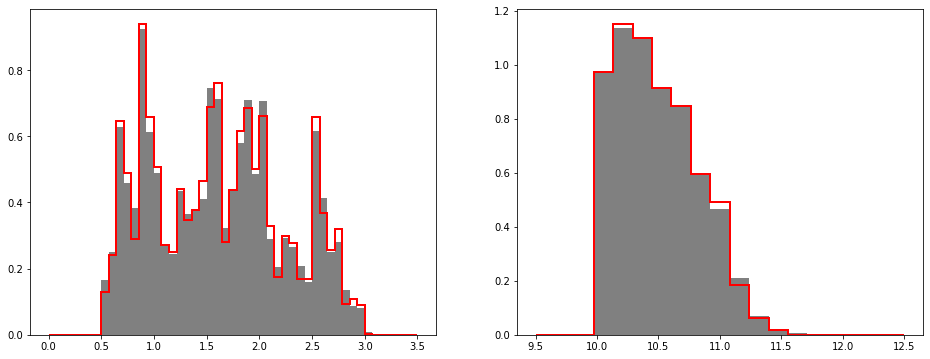

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
zbins = np.linspace(0,3.5,50)
mbins = np.linspace(9.5,12.5,20)
ax[0].hist(pz, bins=zbins, weights=np.concatenate((rdf['pair_prob'],rdf['pair_prob'])), density=True, color='grey')
ax[0].hist(iz, bins=zbins, weights=np.concatenate((cdf['Cp'],cdf['Cp'])), histtype='step', color='red', density=True, lw=2)

ax[1].hist(pmass, bins=mbins, weights=np.concatenate((rdf['pair_prob'],rdf['pair_prob'])), density=True, color='grey')
ax[1].hist(imass, bins=mbins, weights=np.concatenate((cdf['Cp'],cdf['Cp'])), histtype='step', color='red', density=True, lw=2)

plt.show()

In [61]:
# pickle time
with open(PATH+'conv_prob/ALL_FIELDS_HIGH_MASS_8.06.pkl', 'wb') as f: # ID
    pickle.dump(c_dfd, f)

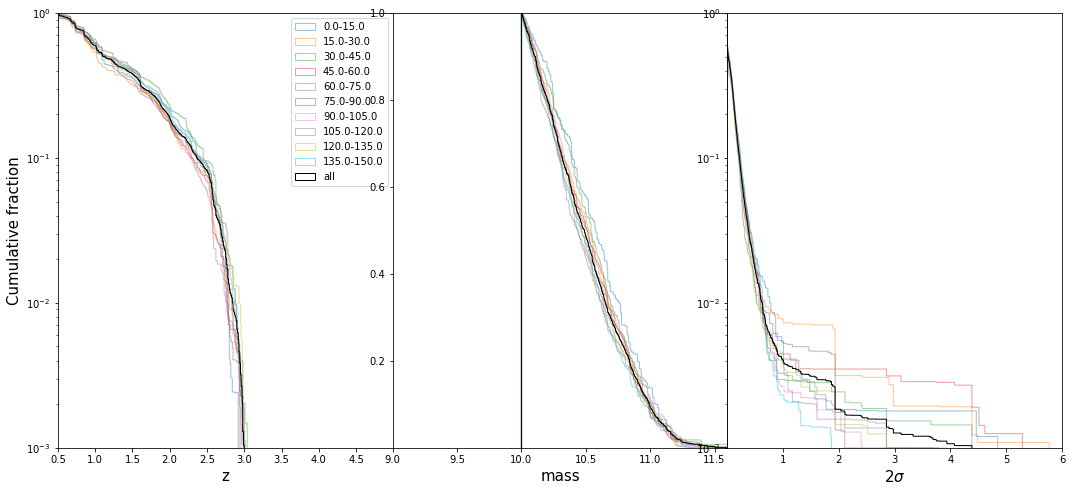

In [24]:
# experiment with weighted distributions
all_bin_z = np.concatenate(pz_bins)
all_bin_mass = np.concatenate(pmass_bins)
all_bin_psig = np.concatenate(psig_bins)
all_bin_prob = np.concatenate(p_probss)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,8), sharey=False)
fig.subplots_adjust(wspace=0)

# plot over each bin:
for i in range(0, len(p_probss)):
    prob = p_probss[i]
    z = pz_bins[i]
    mass = pmass_bins[i]
    sig = psig_bins[i]
    zbins = np.arange(min(z), max(z), 0.001)
    mbins = np.arange(min(mass), max(mass), 0.001)
    sbins = np.arange(min(sig), max(sig), 0.001)
                      

    ax[0].hist(z, weights=prob, bins=zbins, histtype='step', density=True, cumulative=-1, alpha=0.45, label=bins[str(i)])
    ax[0].set_xlim(0.5,4.99)
    ax[0].set_ylim(1e-3,1)
    ax[0].set_xlabel('z', fontsize=15)
    ax[0].set_ylabel('Cumulative fraction', fontsize=15)
    ax[0].set_yscale('log')
    
    ax[1].hist(mass, weights=prob, bins=mbins, histtype='step', density=True, cumulative=-1, alpha=0.45, label=bins[str(i)])
    ax[1].set_xlim(9,11.6)
    ax[1].set_ylim(1e-3,1)
    ax[1].set_xlabel('mass', fontsize=15)
    # ax[1].set_yscale('log')
    
    ax[2].hist(sig, weights=prob, bins=sbins, histtype='step', density=True, cumulative=-1, alpha=0.45, label=bins[str(i)])
    ax[2].set_xlim(0.01,6)
    ax[2].set_ylim(1e-3,1)
    ax[2].set_xlabel('$2\sigma$', fontsize=15)
    ax[2].set_yscale('log')
    
# add on total distribution
zbins = np.arange(min(all_bin_z), max(all_bin_z), 0.001)
mbins = np.arange(min(all_bin_mass), max(all_bin_mass), 0.001)
sbins = np.arange(min(all_bin_psig), max(all_bin_psig), 0.001)
ax[0].hist(all_bin_z, weights=all_bin_prob, bins=zbins, histtype='step', density=True, 
           cumulative=-1, alpha=1, label='all', color='black')
ax[0].legend()
ax[1].hist(all_bin_mass, weights=all_bin_prob, bins=mbins, histtype='step', density=True, 
           cumulative=-1, alpha=1, label='all', color='black')
ax[2].hist(all_bin_psig, weights=all_bin_prob, bins=sbins, histtype='step', density=True, 
           cumulative=-1, alpha=1, label='all', color='black')

plt.show()

In [51]:
# # pickle data to work with in the control galaxy selection sandbox

# with open(PATH+'conv_prob/ID_bins'+str(bottom)+'.pkl', 'wb') as f: # ID
#     pickle.dump(ID_bin, f)
# with open(PATH+'conv_prob/field_bins'+str(bottom)+'.pkl', 'wb') as f: # field
#     pickle.dump(field_bin, f)
# with open(PATH+'conv_prob/z_bins'+str(bottom)+'.pkl', 'wb') as f: # z
#     pickle.dump(pz_bin, f)
# with open(PATH+'conv_prob/mass_bins'+str(bottom)+'.pkl', 'wb') as f: # mass
#     pickle.dump(pmass_bin, f)
# with open(PATH+'conv_prob/sig_bins'+str(bottom)+'.pkl', 'wb') as f: # sig
#     pickle.dump(psig_bin, f)
    

In [52]:
# # plot distributions
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
# # ax[0,0].hist(pz, bins=25, histtype='step', density=True, label='pair')
# # ax[0,0].hist(iz, bins=25, histtype='step', density=True, label='iso')
# # ax[0,0].set_xlabel('z', fontsize=15)
# # ax[0,0].legend()

# ax[0].violinplot(pz_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
# # ax[0,1].violinplot(iz_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
# #                      showextrema=False, showmedians=True, bw_method=0.5)
# ax[0].set_xlabel('kpc', fontsize=15)
# ax[0].set_title('z', fontsize=15)

# # ax[1,0].hist(pmass, bins=25, histtype='step', density=True, label='pair')
# # ax[1,0].hist(imass, bins=25, histtype='step', density=True, label='iso')
# # ax[1,0].set_xlabel('stellar mass', fontsize=15)
# # ax[1,0].legend()

# ax[1].violinplot(pmass_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
# # ax[1,1].violinplot(imass_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
# #                      showextrema=False, showmedians=True, bw_method=0.5)
# ax[1].set_xlabel('kpc', fontsize=15)
# ax[1].set_title('mass', fontsize=15)

# # ax[2,0].hist(psig, bins=25, histtype='step', density=True, label='pair')
# # ax[2,0].hist(isig, bins=25, histtype='step', density=True, label='iso')
# # ax[2,0].set_xlabel('2$\sigma$', fontsize=15)
# # ax[2,0].legend()

# ax[2].violinplot(psig_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
#                      showextrema=False, showmedians=True, bw_method=0.5)
# # ax[2,1].violinplot(isig_bins, kpc_meds,  points=100, widths=vwidth, showmeans=False,
# #                      showextrema=False, showmedians=True, bw_method=0.5)
# ax[2].set_xlabel('kpc', fontsize=15)
# ax[2].set_title('$2\sigma$', fontsize=15)
# ax[2].set_ylim(0,0.5)

# # plt.savefig(PATH+'pp_150kpc_distr.png')

# plt.show()

In [53]:
tot_iso

{'0.0-15.0': 71.94071440623189,
 '15.0-30.0': 157.1001367727778,
 '30.0-45.0': 146.26862069451047,
 '45.0-60.0': 162.12493708772922,
 '60.0-75.0': 179.98674015456047,
 '75.0-90.0': 190.47418124456712,
 '90.0-105.0': 212.77925285649752,
 '105.0-120.0': 260.581777361339,
 '120.0-135.0': 241.8262615603673,
 '135.0-150.0': 239.03326920432838}

In [54]:
# collect count numbers in a df <- FORGET ABOUT ISOLATED GALAXIES FOR NOW
all_pairs_df = pd.DataFrame.from_dict([tot_pair])
all_iso_df = pd.DataFrame.from_dict([tot_iso])
pXAGN_df = pd.DataFrame.from_dict([pXAGN_count])
iXAGN_df = pd.DataFrame.from_dict([iXAGN_count])
pDoAGN_df = pd.DataFrame.from_dict([pDoAGN_count])
iDoAGN_df = pd.DataFrame.from_dict([iDoAGN_count])
pStAGN_df = pd.DataFrame.from_dict([pStAGN_count])
iStAGN_df = pd.DataFrame.from_dict([iStAGN_count])

df = pd.concat([all_pairs_df, pXAGN_df, pDoAGN_df, pStAGN_df,
               all_iso_df, iXAGN_df, iDoAGN_df, iStAGN_df], ignore_index = True, axis=0)
# df = df.rename(index={0: 'Paired Gals', 1: 'Paired X-ray AGN', 2: 'Paired Dale AGN', 
#                       3: 'Paired Donley AGN', 4:'Paired Stern AGN'})
df = df.rename(index={0:'Paired Gals', 1:'Paired X-ray AGN', 2:'Paired Donley AGN', 3:'Paired Stern AGN',
                     4:'Apple Gals', 5:'Apple X-ray AGN', 6:'Apple Donley AGN', 7:'Apple Stern AGN'})

# df = pd.concat([all_pairs_df, pXRAY_df, pDON_df, pSTR_df, pDALE_df,
#                all_iso_df, iXRAY_df, iDON_df, iSTR_df, iDALE_df], ignore_index = True, axis=0)

# df = df.rename(index={0: 'Paired Gals', 1: 'Paired X-ray AGN', 2: 'Paired IR Don AGN', 3: 'Paired IR Str AGN', 4:'Paired Dale AGN',
#                 5: 'Iso Gals', 6: 'Iso X-ray AGN', 7: 'Iso IR Don AGN', 8: 'Iso ID Str AGN', 9: 'Iso Dale AGN'})
df

,0.0-15.0,15.0-30.0,30.0-45.0,45.0-60.0,60.0-75.0,75.0-90.0,90.0-105.0,105.0-120.0,120.0-135.0,135.0-150.0
Paired Gals,36.018698,78.493498,73.065898,81.146815,90.099287,95.187914,106.477998,130.511544,120.964183,119.437697
Paired X-ray AGN,2.954904,3.558030,4.833604,6.434843,6.972404,7.295388,5.167360,7.824793,6.970686,7.254228
Paired Donley AGN,2.109599,1.319466,1.060733,2.934472,2.014518,2.440208,2.003613,3.102796,2.086811,3.173472
Paired Stern AGN,3.422272,5.341581,5.787970,6.622272,7.777268,9.307743,10.095485,13.086827,9.046658,13.273914
Apple Gals,71.940714,157.100137,146.268621,162.124937,179.986740,190.474181,212.779253,260.581777,241.826262,239.033269
Apple X-ray AGN,6.595250,13.367362,9.838870,9.989650,15.890856,12.794623,12.312161,15.361672,14.661158,17.753058
Apple Donley AGN,1.954743,5.140502,4.490068,2.539730,5.138495,5.507973,7.435693,5.587326,7.635058,7.512300
Apple Stern AGN,7.770121,16.631481,14.476384,14.397332,18.364886,20.610998,25.123697,25.877558,26.723635,26.823876


In [55]:
def binomial_err(c, k, n):
    p_lower = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)
    return p_lower, p_upper

In [56]:
pXAGN_err, pXAGN_count

({'0.0-15.0': 0.6777314651102898,
  '15.0-30.0': 0.6434460112870958,
  '30.0-45.0': 0.754686441990847,
  '45.0-60.0': 0.9149496839367198,
  '60.0-75.0': 1.0676312076550245,
  '75.0-90.0': 0.9668424344785564,
  '90.0-105.0': 0.7710448194575016,
  '105.0-120.0': 1.2033267729732948,
  '120.0-135.0': 0.9932412695092845,
  '135.0-150.0': 0.9826653032623864},
 {'0.0-15.0': 2.9549037980091417,
  '15.0-30.0': 3.558030232474494,
  '30.0-45.0': 4.8336035614411115,
  '45.0-60.0': 6.434842841380437,
  '60.0-75.0': 6.972404395647187,
  '75.0-90.0': 7.295388255193556,
  '90.0-105.0': 5.167360065008744,
  '105.0-120.0': 7.824792716991646,
  '120.0-135.0': 6.9706856362467065,
  '135.0-150.0': 7.2542276173091285})

In [57]:
# # calculate 95% binomial confidence intervals based on average AGN fracs and counts
# c = 0.683 #(1 sigma)
# pX_up, pX_lo, pX_fr = {}, {}, {}                     # upper, lower, and frac
# pD_up, pD_lo, pD_fr = {}, {}, {}
# pDo_up, pDo_lo, pDo_fr = {}, {}, {}
# pSt_up, pSt_lo, pSt_fr = {}, {}, {}

# # loop through each col of df above:
# for col in df.columns:
#     p_n = df[col].loc['Paired Gals']
#     # i_n = df[col].loc['Iso Gals']
#     # X-ray first
#     k_pX = df[col].loc['Paired X-ray AGN']
#     pX_lo0, pX_up0 = binomial_err(c, k_pX, p_n)             # function returns y coordinates, not distance from point
#     pX_lo[col] = (k_pX/p_n) - pX_lo0
#     pX_up[col] = pX_up0 - (k_pX/p_n)
#     pX_fr[col] = (k_pX/p_n)
#     # k_XRAY_ISO = df[col].loc['Iso X-ray AGN']
#     # plXRAY_ISO, puXRAY_ISO = binomial_err(c, k_XRAY_ISO, n_ISO)
#     # lXRAY_ISO[col] = (k_XRAY_ISO/n_ISO) - plXRAY_ISO
#     # uXRAY_ISO[col] = puXRAY_ISO - (k_XRAY_ISO/n_ISO)
#     # mXRAY_ISO[col] =  (k_XRAY_ISO/n_ISO)
    
#     # DALE AGN
#     k_pD = df[col].loc['Paired Dale AGN']
#     pD_lo0, pD_up0 = binomial_err(c, k_pD, p_n)
#     pD_lo[col] = (k_pD/p_n) - pD_lo0
#     pD_up[col] = pD_up0 - (k_pD/p_n)
#     pD_fr[col] = (k_pD/p_n)
    
#     # DONLEY IR
#     k_pDo = df[col].loc['Paired Donley AGN']
#     pDo_lo0, pDo_up0 = binomial_err(c, k_pDo, p_n)
#     pDo_lo[col] = (k_pDo/p_n) - pDo_lo0
#     pDo_up[col] = pDo_up0 - (k_pDo/p_n)
#     pDo_fr[col] = (k_pDo/p_n)
#     # k_DON_ISO = df[col].loc['Mean Iso IR Don AGN']
#     # plDON_ISO, puDON_ISO = binomial_err(c, k_DON_ISO, n_ISO)
#     # lDON_ISO[col] = (k_DON_ISO/n_ISO) - plDON_ISO
#     # uDON_ISO[col] = puDON_ISO - (k_DON_ISO/n_ISO)
#     # mDON_ISO[col] = (k_DON_ISO/n_ISO)
    
#     # STERN IR
#     k_pSt = df[col].loc['Paired Stern AGN']
#     pSt_lo0, pSt_up0 = binomial_err(c, k_pSt, p_n)
#     pSt_lo[col] = (k_pSt/p_n) - pSt_lo0
#     pSt_up[col] = pSt_up0 - (k_pSt/p_n)
#     pSt_fr[col] = (k_pSt/p_n)

# # AGN_enh_err = AGN_enh * np.sqrt( (pAGN_err/pAGN_fracs)**2 + (iAGN_err/pAGN_fracs)**2 )

In [58]:
# calculate errors correctly:
# get errors as numpy arrays
pXAGN_err0 = np.array([pXAGN_err[key] for key in pXAGN_err])
pDoAGN_err0 = np.array([pDoAGN_err[key] for key in pDoAGN_err])
pStAGN_err0 = np.array([pStAGN_err[key] for key in pStAGN_err])
p_err0 = np.array([p_err[key] for key in p_err])
iXAGN_err0 = np.array([iXAGN_err[key] for key in iXAGN_err])
iDoAGN_err0 = np.array([iDoAGN_err[key] for key in iDoAGN_err])
iStAGN_err0 = np.array([iStAGN_err[key] for key in iStAGN_err])
i_err0 = np.array([i_err[key] for key in i_err])

pXAGN_count0 = np.array([pXAGN_count[key] for key in pXAGN_count])
pDoAGN_count0 = np.array([pDoAGN_count[key] for key in pDoAGN_count])
pStAGN_count0 = np.array([pXAGN_count[key] for key in pXAGN_count])
iXAGN_count0 = np.array([iXAGN_count[key] for key in iXAGN_count])
iDoAGN_count0 = np.array([iDoAGN_count[key] for key in iDoAGN_count])
iStAGN_count0 = np.array([iXAGN_count[key] for key in iXAGN_count])

pXfrac_err = pXAGN_fracs * np.sqrt( (pXAGN_err0/pXAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pX_uerr = pXAGN_fracs + pXfrac_err
pX_lerr =  pXAGN_fracs - pXfrac_err
pDofrac_err = pDoAGN_fracs * np.sqrt( (pDoAGN_err0/pDoAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pDo_uerr = pDoAGN_fracs + pDofrac_err
pDo_lerr =  pDoAGN_fracs - pDofrac_err
pStfrac_err = pStAGN_fracs * np.sqrt( (pStAGN_err0/pStAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pSt_uerr = pStAGN_fracs + pStfrac_err
pSt_lerr =  pStAGN_fracs - pStfrac_err

iXfrac_err = iXAGN_fracs * np.sqrt( (iXAGN_err0/iXAGN_count0)**2 + (i_err0/tot_isos)**2 )
iX_uerr = iXAGN_fracs + iXfrac_err
iX_lerr =  iXAGN_fracs - iXfrac_err
iDofrac_err = iDoAGN_fracs * np.sqrt( (iDoAGN_err0/iDoAGN_count0)**2 + (i_err0/tot_isos)**2 )
iDo_uerr = iDoAGN_fracs + iDofrac_err
iDo_lerr =  iDoAGN_fracs - iDofrac_err
iStfrac_err = iStAGN_fracs * np.sqrt( (iStAGN_err0/iStAGN_count0)**2 + (i_err0/tot_isos)**2 )
iSt_uerr = iStAGN_fracs + iStfrac_err
iSt_lerr =  iStAGN_fracs - iStfrac_err

In [59]:
pStfrac_err

array([0.02450239, 0.01687322, 0.01505419, 0.0135358 , 0.01489968,
       0.01702134, 0.02576696, 0.02110743, 0.01313353, 0.02365679])

In [60]:
# # prepare for violin plots
# pX_uerr = [pX_up[col] for col in pX_up]
# pX_lerr = [pX_lo[col] for col in pX_lo]
# pX_fr = [pX_fr[col] for col in pX_fr]
# # idata_uerr = [uXRAY_ISO[col] for col in uXRAY_ISO]
# # idata_lerr = [lXRAY_ISO[col] for col in lXRAY_ISO]
# # idata_m = [mXRAY_ISO[col] for col in mXRAY_ISO]

# pD_uerr = [pD_up[col] for col in pD_up]
# pD_lerr =  [pD_lo[col] for col in pD_lo]
# pD_fr = [pD_fr[col] for col in pD_fr]
# # iDON_uerr = [uDON_ISO[col] for col in uDON_ISO]
# # iDON_lerr =  [lDON_ISO[col] for col in lDON_ISO]
# # iDON_m = [mDON_ISO[col] for col in mDON_ISO]

# pDo_uerr = [pDo_up[col] for col in pDo_up]
# pDo_lerr =  [pDo_lo[col] for col in pDo_lo]
# pDo_fr = [pDo_fr[col] for col in pDo_fr]
# # iDALE_uerr = [uDALE_ISO[col] for col in uDALE_ISO]
# # iDALE_lerr =  [lDALE_ISO[col] for col in lDALE_ISO]
# # iDALE_m = [mDALE_ISO[col] for col in mDALE_ISO]

# pSt_uerr = [pSt_up[col] for col in pSt_up]
# pSt_lerr =  [pSt_lo[col] for col in pSt_lo]
# pSt_fr = [pSt_fr[col] for col in pSt_fr]

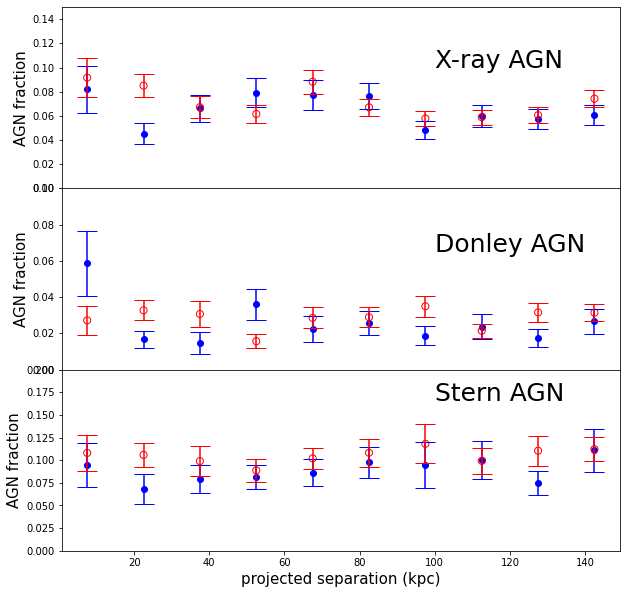

In [61]:
# plot AGN fractions / enhancement:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0)
# X-ray
ax[0].scatter(kpc_meds, pXAGN_fracs, color='blue')
ax[0].errorbar(kpc_meds, pXAGN_fracs, yerr=(pXfrac_err,pXfrac_err), linestyle="None", capsize=10, color='blue')
ax[0].scatter(kpc_meds, iXAGN_fracs, s=50, facecolor='none', edgecolor='red')
ax[0].errorbar(kpc_meds, iXAGN_fracs, yerr=(iXfrac_err,iXfrac_err), linestyle="None", capsize=10, color='red')
ax[0].set_ylim(0, 0.15)
ax[0].set_ylabel('AGN fraction', fontsize=15)
# ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].text(100,0.1,'X-ray AGN', fontsize=25)

# Donley
ax[1].scatter(kpc_meds, pDoAGN_fracs, color='blue')
ax[1].errorbar(kpc_meds, pDoAGN_fracs, yerr=(pDofrac_err,pDofrac_err), linestyle="None", capsize=10, color='blue')
ax[1].scatter(kpc_meds, iDoAGN_fracs, s=50, facecolor='none', edgecolor='red')
ax[1].errorbar(kpc_meds, iDoAGN_fracs, yerr=(iDofrac_err,iDofrac_err), linestyle="None", capsize=10, color='red')
ax[1].set_ylim(0, 0.1)
# ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_ylabel('AGN fraction', fontsize=15)
ax[1].text(100,0.065,'Donley AGN', fontsize=25)

# Stern
ax[2].scatter(kpc_meds, pStAGN_fracs, color='blue')
ax[2].errorbar(kpc_meds, pStAGN_fracs, yerr=(pStfrac_err,pStfrac_err), linestyle="None", capsize=10, color='blue')
ax[2].scatter(kpc_meds, iStAGN_fracs, s=50, facecolor='none', edgecolor='red')
ax[2].errorbar(kpc_meds, iStAGN_fracs, yerr=(iStfrac_err,iStfrac_err), linestyle="None", capsize=10, color='red')
ax[2].set_ylim(0, 0.2)
ax[2].set_xlabel('projected separation (kpc)', fontsize=15)
ax[2].set_ylabel('AGN fraction', fontsize=15)
ax[2].text(100,0.165, 'Stern AGN', fontsize=25)



# ax[0].set_xticks(np.arange(0,150,20))
# ax[0].set_xticklabels(np.arange(0,150,20),fontsize=15)
# ax[0].set_yticks(np.arange(0,0.12,0.02))
# ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)


# ax[1].set_xticks(np.arange(0,150,20))
# ax[1].set_xticklabels(np.arange(0,150,20),fontsize=15)

# plt.savefig(PATH+'AP_PP_150kpc.png')
plt.show()

In [62]:
# calculate AGN enhancement and propogate error once more:
Enh_X = pXAGN_fracs / iXAGN_fracs
Enh_X_err = Enh_X * np.sqrt( (pXfrac_err/pXAGN_fracs)**2 + (iXfrac_err/iXAGN_fracs)**2 )
Enh_DoIR = pDoAGN_fracs / iDoAGN_fracs
Enh_DoIR_err = Enh_DoIR * np.sqrt( (pDofrac_err/pDoAGN_fracs)**2 + (iDofrac_err/iDoAGN_fracs)**2 )
Enh_StIR = pStAGN_fracs / iStAGN_fracs
Enh_StIR_err = Enh_StIR * np.sqrt( (pStfrac_err/pStAGN_fracs)**2 + (iStfrac_err/iStAGN_fracs)**2 )

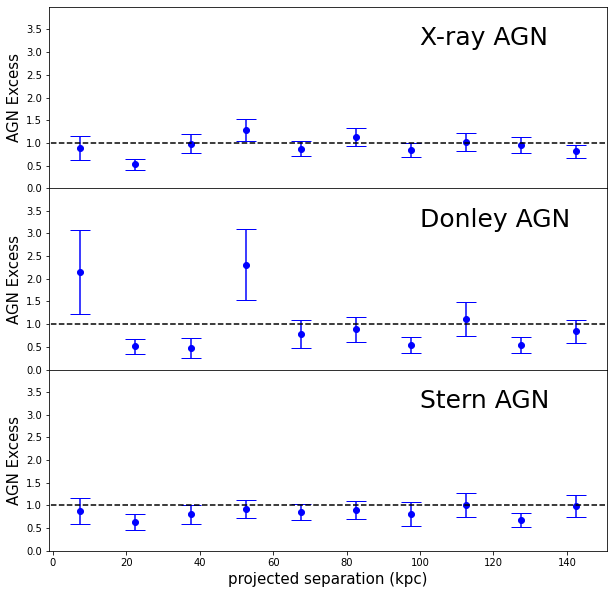

In [65]:
# AGN enhancement plot:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0)
# X-ray
ax[0].scatter(kpc_meds, Enh_X, color='blue')
ax[0].errorbar(kpc_meds, Enh_X, yerr=(Enh_X_err,Enh_X_err), linestyle="None", capsize=10, color='blue')
ax[0].plot([-5,200], [1,1], linestyle='--', color='black')
ax[0].set_ylim(0, 3.99)
ax[0].set_xlim(-1,151)
ax[0].set_ylabel('AGN Excess', fontsize=15)
# ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].text(100,3.15,'X-ray AGN', fontsize=25)

# Donley
ax[1].scatter(kpc_meds, Enh_DoIR, color='blue')
ax[1].errorbar(kpc_meds, Enh_DoIR, yerr=(Enh_DoIR_err,Enh_DoIR_err), linestyle="None", capsize=10, color='blue')
ax[1].plot([-5,200], [1,1], linestyle='--', color='black')
ax[1].set_ylim(0, 3.99)
# ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_ylabel('AGN Excess', fontsize=15)
ax[1].text(100,3.15,'Donley AGN', fontsize=25)

# Stern
ax[2].scatter(kpc_meds, Enh_StIR, color='blue')
ax[2].errorbar(kpc_meds, Enh_StIR, yerr=(Enh_StIR_err,Enh_StIR_err), linestyle="None", capsize=10, color='blue')
ax[2].plot([-5,200], [1,1], linestyle='--', color='black')
ax[2].set_ylim(0, 3.99)
ax[2].set_xlabel('projected separation (kpc)', fontsize=15)
ax[2].set_ylabel('AGN Excess', fontsize=15)
ax[2].text(100,3.15, 'Stern AGN', fontsize=25)

plt.show()

In [107]:
Enh_DoIR

array([2.01521484, 0.62068151, 0.66002305, 2.13773504, 1.23650571,
       1.14849049, 0.5713416 , 0.85229516, 0.61287455, 0.79048303])

In [23]:
pXAGN_fracs, pDoAGN_fracs, pStAGN_fracs

(array([0.07828391, 0.04519548, 0.06496871, 0.07930884, 0.07606342,
        0.07775845, 0.04889475, 0.0588383 , 0.05889336, 0.06174766]),
 array([0.05583934, 0.0168687 , 0.01374467, 0.03644657, 0.02325875,
        0.02530659, 0.01977653, 0.02295418, 0.0172902 , 0.02624237]),
 array([0.1086457 , 0.06883286, 0.07805562, 0.08192942, 0.08701024,
        0.10064144, 0.09289594, 0.10224887, 0.07146827, 0.11220328]))

In [24]:
pXfrac_err, pDofrac_err, pStfrac_err

(array([0.01864913, 0.00845825, 0.01078445, 0.01192996, 0.01230557,
        0.01078784, 0.00774609, 0.00964812, 0.00863517, 0.00860918]),
 array([0.017002  , 0.00470451, 0.0059627 , 0.00850556, 0.00802351,
        0.00663122, 0.00558004, 0.00687806, 0.00496322, 0.00672628]),
 array([0.0374207 , 0.01709178, 0.01502158, 0.01361816, 0.01566145,
        0.01753949, 0.02494775, 0.02238214, 0.01205421, 0.02374913]))

In [20]:
kpc_meds

[7.5, 22.5, 37.5, 52.5, 67.5, 82.5, 97.5, 112.5, 127.5, 142.5]

In [163]:
# rdf

In [ ]:
df = bin_dfs['0.0-15.0'] # 30.0-45.0
df.loc[ df['prime_IR_AGN_DON'] > 0, ['prime_z','prime_M','prime_ID', 'prime_LX', 'prime_IR_AGN_DON', 'prime_IR_AGN_STR', 'prime_DALE_AGN_FLAG', 'field' ]]

In [ ]:
# Now think about control galaxy selection... 
# the general idea now is to use the distribution of redshift, mass, and and sigma to get control selection
# from purely the fractional pair counts...

# but first we need to get some numbers... I want to know for each field
# 1) total isolated sample simply from initial projected pair analysis
# 2) how many would be added back with the introduction of a bottoming out
# 3) the percent change that bottoming out would have...
# perhaps I should do this in a separate notebook...

In [ ]:
data = np.array([pX_fr, pX_lerr, pX_uerr, pDo_fr, pDo_lerr, pDo_uerr, pSt_fr, pSt_lerr, pSt_uerr])
df = pd.DataFrame(data)
df = df.T
df = df.rename(columns={0:'pX_fr',1:'pX_lerr',2:'pX_uerr',
                        3:'pDo_fr',4:'pDo_lerr',5:'pDo_uerr',
                        6:'pSt_fr',7:'pSt_lerr',8:'pSt_uerr'})
# df.to_csv(PATH+'conv_results.csv', index=False)

In [ ]:
# save all the plotting data as a df
# bins as rows, columns are 

## pair fraction vs redshift

In [ ]:
# first thing to do is to load in CANDELS data and simply count all source in mass and z range
nPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/Pair Project - Updated Data/'
cPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
fields = ['GDS','EGS','COS','GDN','UDS','COSMOS']
field_pcounts = {}
all_pcounts = {}
field_counts = {}
all_counts = {}
zmins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5]
zmaxs = [1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5, 6.5]

# populate all dicts:
for i in range(0, len(zmins)):
    all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = 0
    all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = 0

# load in results:
# file = 'pair_prob/PP_ALL_FIELDS.csv'
file = 'conv_prob/CP_ALL_FIELDS.csv'
rdf = pd.read_csv(PATH+file)
# rdf['pair_prob'] = rdf['pair_prob']/100 # only for pp method

for field in fields:
    print(field)
    if field == 'COSMOS':
        df = pd.read_csv(cPATH+'select_COSMOS2020.csv')
        df['SIG_DIFF'] = df['lp_zPDF_u68'] - df['lp_zPDF_l68']
        df = df[ (df['lp_type'] != 1) & (df['lp_type'] != -99) & (df['lp_mass_med'] > 10.3) & 
           (df['FLAG_COMBINED'] == 0) & (df['lp_zPDF'] > 0.5) & (df['lp_zPDF'] < 6.5) ]
        df = df.rename(columns={'ALPHA_J2000':'RA', 'DELTA_J2000':'DEC', 'lp_mass_med':'MASS', 'lp_zPDF':'ZPHOT_PEAK',
                               'F0.5-10_2015':'FX', 'UVISTA_H_MAG_APER2':'HMAG'})
        all_df = df.reset_index(drop=True)
    else:
        df = pd.read_csv(nPATH+'CANDELS_Catalogs/CANDELS.'+field+'.1018.Lx_best.wFx_AIRD.csv')
        df_phot = pd.read_csv(nPATH+'redshift_catalogs.full/zcat_'+field+'_v2.0.cat', names=['file','ID','RA','DEC','z_best',
                        'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                        'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                        'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                        'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                        'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                        'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                        'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                        'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                        'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                        'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                           delimiter=' ', comment='#')
        # match based on ID as GDN has ID weirdness
        df_phot = df_phot.loc[ (df_phot['ID'].isin(df['ID']) == True) ]
        df_phot = df_phot.reset_index(drop=True)
        df['ZPHOT_PEAK'] = df_phot['mFDa4_z_peak'] # might want to use weight for consistency with COSMOS
        df['SIG_DIFF'] = df_phot['mFDa4_z683_high'] - df_phot['mFDa4_z683_low']
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > 10.3) & 
                (df['ZPHOT_PEAK'] > 0.5) & (df['ZPHOT_PEAK'] < 6.5) ]
        all_df = df.reset_index(drop=True)
    
    pair_count = {}
    all_count = {}
    for i in range(0, len(zmins)):
        # for pairs
        zdf = rdf[ (rdf['kpc_sep'] >= 5) & (rdf['kpc_sep'] <= 30) & (rdf['mass_ratio'] < np.log10(4/1)) &
                 (rdf['prime_M'] > 10.3) & (rdf['prime_z'] >= zmins[i]) & (rdf['prime_z'] < zmaxs[i]) & 
                  (rdf['field'] == field) & (rdf['pair_prob'] > 0.01) ]
        pair_count[str(zmins[i])+'-'+str(zmaxs[i])] = np.sum(zdf['pair_prob'])
        all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] + np.sum(zdf['pair_prob'])
        
        # for all data
        zall_df = all_df[ (all_df['ZPHOT_PEAK'] >= zmins[i]) & (all_df['ZPHOT_PEAK'] < zmaxs[i]) ]
        all_count[str(zmins[i])+'-'+str(zmaxs[i])] = len(zall_df)
        all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = all_counts[str(zmins[i])+'-'+str(zmaxs[i])] + len(zall_df)
        
    field_pcounts[field] = pair_count
    field_counts[field] = all_count
    
field_pcounts['ALL'] = all_pcounts
field_counts['ALL'] = all_counts

In [ ]:
pair_frac = {}
fields.append('ALL')
for field in field_pcounts:
    fracs = {}
    for zbin in field_pcounts[field]:
        fracs[zbin] = field_pcounts[field][zbin] / field_counts[field][zbin]
        pair_frac[field] = fracs

In [ ]:
# field_pcounts

In [ ]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
colors = ['purple','red','green','blue','orange','pink','black']
for i, field in enumerate(field_pcounts):
    if field == 'ALL':
        ax.scatter(-1,-1, s=50, facecolor=colors[i], label=field)
    else:
        ax.scatter(-1,-1,s=25, edgecolor=colors[i], facecolor='none', label=field)
    for zbin in field_pcounts[field]:
        x = zbin.split('-')
        z = ((float(x[0]) + float(x[1])) / 2) + 0.02*i
        if field == 'ALL':
            ax.scatter(z, pair_frac[field][zbin], s=5, facecolor=colors[i])
        else:
            ax.scatter(z, pair_frac[field][zbin], s=25, edgecolor=colors[i], facecolor='none')
plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,6.5)
plt.legend()
plt.show()

In [ ]:
# rdf[ rdf['kpc_sep'] < 30 ]
#